In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math

from Data import *
from nets.MLP import MLP
from nets.LTU import LTU, encoder, decoder
from flows.build import build_flow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Base distribution

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 2
Data = Data('two_moons.csv')

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

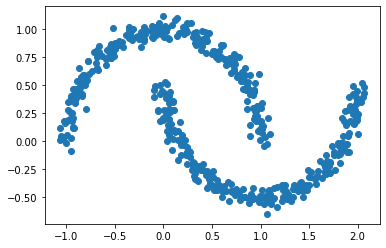

In [5]:
Data.plot_scatter()

## RealNVP

In [6]:
net = MLP(ip = 1, out = 2)
net

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): GELU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): GELU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [7]:
flow_realnvp = build_flow(name = 'realnvp', net = net, dim= 7, device = device).flow.to(device)
# print(flow_realnvp)

In [8]:
#Train

optimizer = torch.optim.Adam(flow_realnvp.parameters(), lr=1e-3)
epochs = 1000

print('Training...')
flow_realnvp = flow_realnvp.train()
for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        z, log_det = flow_realnvp.flow_outputs(x)
        log_prob = base_dist().log_prob(z).sum(1) + log_det
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
flow_realnvp = flow_realnvp.eval()

Training...
Epoch: 1/200, Loss: -1.855
Epoch: 2/200, Loss: -2.226
Epoch: 3/200, Loss: -2.437
Epoch: 4/200, Loss: -2.080
Epoch: 5/200, Loss: -2.569
Epoch: 6/200, Loss: -2.555
Epoch: 7/200, Loss: -2.624
Epoch: 8/200, Loss: -2.644
Epoch: 9/200, Loss: -2.861
Epoch: 10/200, Loss: -2.986
Epoch: 11/200, Loss: -2.946
Epoch: 12/200, Loss: -2.776
Epoch: 13/200, Loss: -3.026
Epoch: 14/200, Loss: -3.143
Epoch: 15/200, Loss: -3.234
Epoch: 16/200, Loss: -3.309
Epoch: 17/200, Loss: -3.245
Epoch: 18/200, Loss: -3.310
Epoch: 19/200, Loss: -3.488
Epoch: 20/200, Loss: -3.535
Epoch: 21/200, Loss: -3.397
Epoch: 22/200, Loss: -3.659
Epoch: 23/200, Loss: -3.437
Epoch: 24/200, Loss: -3.582
Epoch: 25/200, Loss: -3.689
Epoch: 26/200, Loss: -3.658
Epoch: 27/200, Loss: -3.692
Epoch: 28/200, Loss: -3.668
Epoch: 29/200, Loss: -3.733
Epoch: 30/200, Loss: -3.560
Epoch: 31/200, Loss: -3.804
Epoch: 32/200, Loss: -3.800
Epoch: 33/200, Loss: -3.768
Epoch: 34/200, Loss: -3.870
Epoch: 35/200, Loss: -3.720
Epoch: 36/200, Lo

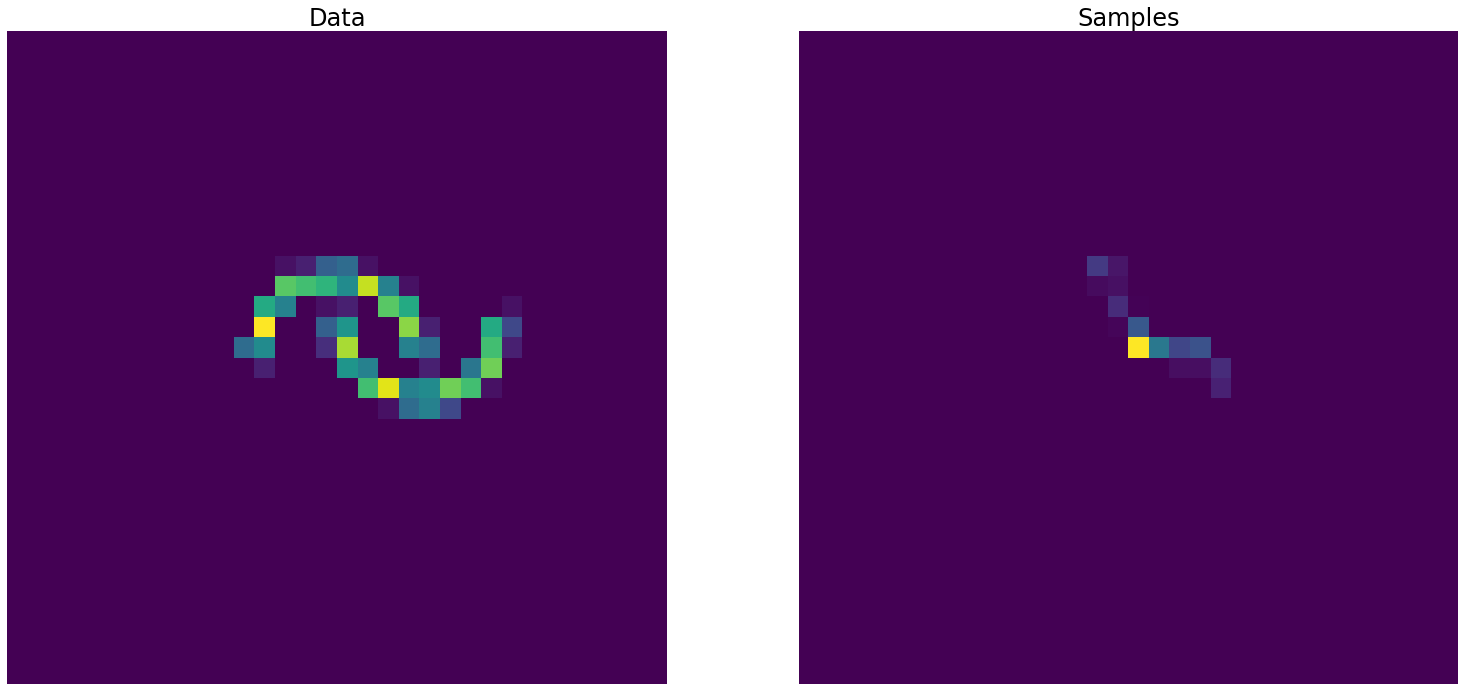

In [9]:
Data.plot_samples(flow_realnvp.sample(400))

## Planar

In [10]:
enc = encoder(hidden_sizes=[128, 64, 2*2]).to(device)
net = LTU()
dec = decoder(hidden_sizes=[64, 128, 2]).to(device)
net

LTU(
  (layer1): Matmul()
  (layer2): Matadd()
  (layer3): Tanh()
  (layer4): Matmul()
)

In [11]:
flow_planar= build_flow(name = 'planar', net = net, dim= 10, device = device).flow.to(device)
# print(flow_planar)

In [12]:
loss_fn = BCEWithLogitsLoss()

#Train

optimizer = torch.optim.Adam(list(enc.parameters()) + list(flow_planar.parameters()) + list(dec.parameters()))
epochs = 1500

print('Training...')

flow_planar = flow_planar.train()

for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        batch_size = len(x)
        x = x.to(device)
        optimizer.zero_grad()
        x_ = enc(x)
        mu, log_sigma = x_[:,0:2], x_[:,2:4]
        sigma = torch.exp(log_sigma)
        
        # Sample from z ~ N(0,I).        
        z = torch.zeros(size= [batch_size,1]).normal_(mean=0, std=1)
        z = z.to(device)
        z0 = z*sigma + mu
        
        log_prob_z0 = torch.sum(-0.5 * torch.log(torch.tensor(2 * math.pi)) - 
                                log_sigma - 0.5 * ((z0 - mu) / sigma) ** 2, axis=1)
        
        zk, log_det = flow_planar.flow_outputs(z0)
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2 * math.pi))+ zk ** 2), axis=1)
        x_hat = dec(zk)

        loss = torch.mean(log_prob_z0) + loss_fn(x_hat, x) - torch.mean(log_prob_zk) - torch.mean(log_det)
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
flow_planar = flow_planar.eval()

Training...
Epoch: 1/1500, Loss: -3.755
Epoch: 2/1500, Loss: -6.139
Epoch: 3/1500, Loss: -9.130
Epoch: 4/1500, Loss: -12.313
Epoch: 5/1500, Loss: -14.898
Epoch: 6/1500, Loss: -17.004
Epoch: 7/1500, Loss: -18.883
Epoch: 8/1500, Loss: -20.551
Epoch: 9/1500, Loss: -22.088
Epoch: 10/1500, Loss: -23.488
Epoch: 11/1500, Loss: -24.803
Epoch: 12/1500, Loss: -26.045
Epoch: 13/1500, Loss: -27.173
Epoch: 14/1500, Loss: -28.268
Epoch: 15/1500, Loss: -29.292
Epoch: 16/1500, Loss: -30.295
Epoch: 17/1500, Loss: -31.238
Epoch: 18/1500, Loss: -32.145
Epoch: 19/1500, Loss: -33.028
Epoch: 20/1500, Loss: -33.862
Epoch: 21/1500, Loss: -34.697
Epoch: 22/1500, Loss: -35.475
Epoch: 23/1500, Loss: -36.238
Epoch: 24/1500, Loss: -36.995
Epoch: 25/1500, Loss: -37.717
Epoch: 26/1500, Loss: -38.411
Epoch: 27/1500, Loss: -39.102
Epoch: 28/1500, Loss: -39.769
Epoch: 29/1500, Loss: -40.425
Epoch: 30/1500, Loss: -41.058
Epoch: 31/1500, Loss: -41.679
Epoch: 32/1500, Loss: -42.285
Epoch: 33/1500, Loss: -42.882
Epoch: 34/

Epoch: 269/1500, Loss: -74.852
Epoch: 270/1500, Loss: -74.893
Epoch: 271/1500, Loss: -74.830
Epoch: 272/1500, Loss: -74.974
Epoch: 273/1500, Loss: -75.013
Epoch: 274/1500, Loss: -75.056
Epoch: 275/1500, Loss: -75.095
Epoch: 276/1500, Loss: -75.137
Epoch: 277/1500, Loss: -75.172
Epoch: 278/1500, Loss: -75.164
Epoch: 279/1500, Loss: -75.071
Epoch: 280/1500, Loss: -75.250
Epoch: 281/1500, Loss: -75.332
Epoch: 282/1500, Loss: -75.371
Epoch: 283/1500, Loss: -75.409
Epoch: 284/1500, Loss: -75.446
Epoch: 285/1500, Loss: -75.485
Epoch: 286/1500, Loss: -75.524
Epoch: 287/1500, Loss: -75.564
Epoch: 288/1500, Loss: -75.601
Epoch: 289/1500, Loss: -75.625
Epoch: 290/1500, Loss: -75.640
Epoch: 291/1500, Loss: -75.715
Epoch: 292/1500, Loss: -75.754
Epoch: 293/1500, Loss: -75.792
Epoch: 294/1500, Loss: -75.675
Epoch: 295/1500, Loss: -75.865
Epoch: 296/1500, Loss: -75.904
Epoch: 297/1500, Loss: -75.939
Epoch: 298/1500, Loss: -75.977
Epoch: 299/1500, Loss: -76.013
Epoch: 300/1500, Loss: -76.048
Epoch: 3

Epoch: 534/1500, Loss: -82.210
Epoch: 535/1500, Loss: -82.196
Epoch: 536/1500, Loss: -82.247
Epoch: 537/1500, Loss: -82.238
Epoch: 538/1500, Loss: -82.275
Epoch: 539/1500, Loss: -82.306
Epoch: 540/1500, Loss: -81.912
Epoch: 541/1500, Loss: -82.279
Epoch: 542/1500, Loss: -82.366
Epoch: 543/1500, Loss: -82.386
Epoch: 544/1500, Loss: -82.406
Epoch: 545/1500, Loss: -82.163
Epoch: 546/1500, Loss: -82.432
Epoch: 547/1500, Loss: -82.463
Epoch: 548/1500, Loss: -82.483
Epoch: 549/1500, Loss: -82.500
Epoch: 550/1500, Loss: -82.520
Epoch: 551/1500, Loss: -82.388
Epoch: 552/1500, Loss: -81.899
Epoch: 553/1500, Loss: -82.576
Epoch: 554/1500, Loss: -82.594
Epoch: 555/1500, Loss: -82.614
Epoch: 556/1500, Loss: -82.632
Epoch: 557/1500, Loss: -82.652
Epoch: 558/1500, Loss: -82.672
Epoch: 559/1500, Loss: -82.676
Epoch: 560/1500, Loss: -82.446
Epoch: 561/1500, Loss: -82.711
Epoch: 562/1500, Loss: -82.746
Epoch: 563/1500, Loss: -82.764
Epoch: 564/1500, Loss: -82.770
Epoch: 565/1500, Loss: -82.794
Epoch: 5

Epoch: 799/1500, Loss: -86.362
Epoch: 800/1500, Loss: -86.374
Epoch: 801/1500, Loss: -86.387
Epoch: 802/1500, Loss: -86.397
Epoch: 803/1500, Loss: -86.409
Epoch: 804/1500, Loss: -86.422
Epoch: 805/1500, Loss: -86.433
Epoch: 806/1500, Loss: -86.446
Epoch: 807/1500, Loss: -86.459
Epoch: 808/1500, Loss: -86.112
Epoch: 809/1500, Loss: -85.957
Epoch: 810/1500, Loss: -86.495
Epoch: 811/1500, Loss: -86.507
Epoch: 812/1500, Loss: -86.521
Epoch: 813/1500, Loss: -86.533
Epoch: 814/1500, Loss: -86.547
Epoch: 815/1500, Loss: -86.559
Epoch: 816/1500, Loss: -86.061
Epoch: 817/1500, Loss: -86.582
Epoch: 818/1500, Loss: -86.595
Epoch: 819/1500, Loss: -86.607
Epoch: 820/1500, Loss: -86.621
Epoch: 821/1500, Loss: -86.635
Epoch: 822/1500, Loss: -84.514
Epoch: 823/1500, Loss: -86.635
Epoch: 824/1500, Loss: -86.668
Epoch: 825/1500, Loss: -86.681
Epoch: 826/1500, Loss: -86.693
Epoch: 827/1500, Loss: -86.705
Epoch: 828/1500, Loss: -86.719
Epoch: 829/1500, Loss: -86.731
Epoch: 830/1500, Loss: -86.743
Epoch: 8

Epoch: 1062/1500, Loss: -89.184
Epoch: 1063/1500, Loss: -89.193
Epoch: 1064/1500, Loss: -89.201
Epoch: 1065/1500, Loss: -89.212
Epoch: 1066/1500, Loss: -89.170
Epoch: 1067/1500, Loss: -86.278
Epoch: 1068/1500, Loss: -89.234
Epoch: 1069/1500, Loss: -89.245
Epoch: 1070/1500, Loss: -89.253
Epoch: 1071/1500, Loss: -89.263
Epoch: 1072/1500, Loss: -89.273
Epoch: 1073/1500, Loss: -89.282
Epoch: 1074/1500, Loss: -89.292
Epoch: 1075/1500, Loss: -89.301
Epoch: 1076/1500, Loss: -89.301
Epoch: 1077/1500, Loss: -89.277
Epoch: 1078/1500, Loss: -87.939
Epoch: 1079/1500, Loss: -89.155
Epoch: 1080/1500, Loss: -89.347
Epoch: 1081/1500, Loss: -89.358
Epoch: 1082/1500, Loss: -89.367
Epoch: 1083/1500, Loss: -89.377
Epoch: 1084/1500, Loss: -89.386
Epoch: 1085/1500, Loss: -89.381
Epoch: 1086/1500, Loss: -88.737
Epoch: 1087/1500, Loss: -89.414
Epoch: 1088/1500, Loss: -89.425
Epoch: 1089/1500, Loss: -89.333
Epoch: 1090/1500, Loss: -89.291
Epoch: 1091/1500, Loss: -89.276
Epoch: 1092/1500, Loss: -88.775
Epoch: 1

Epoch: 1319/1500, Loss: -89.181
Epoch: 1320/1500, Loss: -83.432
Epoch: 1321/1500, Loss: -91.194
Epoch: 1322/1500, Loss: -91.199
Epoch: 1323/1500, Loss: -91.203
Epoch: 1324/1500, Loss: -91.209
Epoch: 1325/1500, Loss: -91.214
Epoch: 1326/1500, Loss: -91.220
Epoch: 1327/1500, Loss: -91.225
Epoch: 1328/1500, Loss: -91.233
Epoch: 1329/1500, Loss: -91.239
Epoch: 1330/1500, Loss: -91.246
Epoch: 1331/1500, Loss: -91.237
Epoch: 1332/1500, Loss: -91.206
Epoch: 1333/1500, Loss: -89.780
Epoch: 1334/1500, Loss: -90.995
Epoch: 1335/1500, Loss: -90.948
Epoch: 1336/1500, Loss: -91.277
Epoch: 1337/1500, Loss: -91.296
Epoch: 1338/1500, Loss: -91.304
Epoch: 1339/1500, Loss: -91.309
Epoch: 1340/1500, Loss: -91.228
Epoch: 1341/1500, Loss: -90.335
Epoch: 1342/1500, Loss: -90.572
Epoch: 1343/1500, Loss: -91.340
Epoch: 1344/1500, Loss: -91.308
Epoch: 1345/1500, Loss: -91.338
Epoch: 1346/1500, Loss: -90.398
Epoch: 1347/1500, Loss: -91.364
Epoch: 1348/1500, Loss: -91.378
Epoch: 1349/1500, Loss: -91.386
Epoch: 1

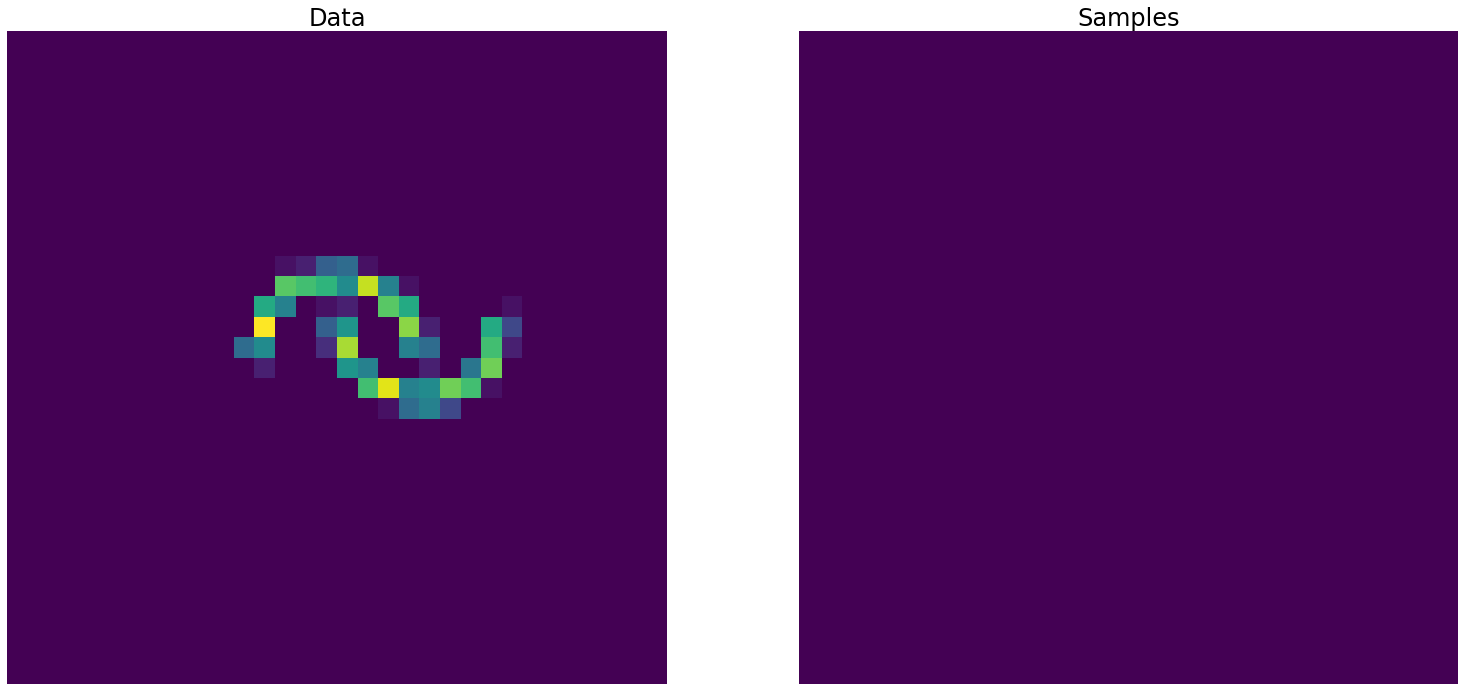

In [17]:
Data.plot_samples(flow_planar.sample(1000))

In [16]:
x_hat

tensor([[0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<ReluBackward0>)

In [15]:
plt.scatter(x_hat)

TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
# if batch_num % 10 == 0:
#     print(f"(batch_num {batch_num:05d}/{num_batches}) loss: {loss}")